# Load dataset

In [ ]:
!pip install kaggle

In [ ]:
import os
import zipfile

def download_data_from_kaggle():
    try:
        from google.colab import files
        uploaded = files.upload()
    except ImportError:
        print("Running outside of Colab. Please ensure your kaggle.json is in ~/.kaggle/")

    if 'kaggle.json' in os.listdir('.'):
        !mkdir -p ~/.kaggle
        !mv kaggle.json ~/.kaggle/
        !chmod 600 ~/.kaggle/kaggle.json
    else:
        print("kaggle.json not found. Please upload it or place it in the correct directory.")

    if not os.path.exists('cpe342-karena.zip'):
        print("Downloading data from Kaggle competition 'cpe342-karena'...")
        !kaggle competitions download -c cpe342-karena
    else:
        print("Data already downloaded.")

    if os.path.exists('cpe342-karena.zip'):
        print("Unzipping data...")
        try:
            with zipfile.ZipFile('cpe342-karena.zip', 'r') as zip_ref:
                zip_ref.extractall('.')
            print("Data unzipped.")
        except zipfile.BadZipFile:
            print("Error: Downloaded file is not a valid zip file.")
        except Exception as e:
            print(f"An error occurred during unzipping: {e}")
    else:
        print("Zip file not found, cannot unzip.")

In [ ]:
download_data_from_kaggle()

Saving kaggle.json to kaggle.json
Data already downloaded.
Unzipping data...
Data unzipped.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Modeling

# Task 3 Load and Clean data

In [ ]:
# --- Libraries for Task 3 --- (Re-importing and installing missing ones)
import os
import gc
import joblib
import math
import numpy as np
import pandas as pd
from pathlib import Path

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error
from sklearn.calibration import CalibratedClassifierCV

import lightgbm as lgb
from lightgbm import LGBMRegressor
from catboost import CatBoostClassifier, CatBoostRegressor

!pip install optuna shap
import optuna
import shap
import matplotlib.pyplot as plt
import seaborn as sns

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 11.8 MB/s eta 0:00:00


In [ ]:
df = pd.read_csv("task3/train.csv")   # path from earlier upload
print(df.shape)
df.head()


(104000, 35)


,id,player_id,friend_count,social_interactions,guild_membership,event_participation_rate,daily_login_streak,avg_session_length,sessions_per_week,total_playtime_hours,...,purchase_frequency,payment_methods_used,purchases_on_discount,discount_rate_used,seasonal_spending_pattern,owns_limited_edition,competitive_rank,tournament_participation,segment,spending_30d
0,PLY00001,P007453,140.0,39.0,NaN,35.495321,86.0,94.186687,20.660400,793.043827,...,NaN,1.0,1.0,0.250000,4.0,NaN,7.0,1.0,1.0,0.00
1,PLY00002,P120776,126.0,12.0,1.0,35.222611,27.0,76.694036,15.112974,836.397667,...,11.193590,1.0,25.0,0.581395,5.0,0.0,3.0,0.0,1.0,0.00
2,PLY00003,P083055,157.0,63.0,1.0,54.291374,1.0,66.680997,13.770480,561.212807,...,5.175272,3.0,27.0,0.551020,7.0,0.0,5.0,0.0,1.0,0.00
3,PLY00004,P087827,89.0,96.0,1.0,52.990011,74.0,75.864572,11.941930,NaN,...,10.374656,2.0,22.0,0.536585,6.0,0.0,9.0,0.0,2.0,2223.70
4,PLY00005,P045133,159.0,80.0,0.0,78.586509,84.0,33.774836,1.405901,617.041867,...,NaN,3.0,11.0,0.261905,0.0,1.0,4.0,0.0,3.0,156634.22


In [ ]:
print("Target summary:")
print(df["spending_30d"].describe())
zero_rate = (df["spending_30d"] == 0).mean()
print(f"Zero fraction: {zero_rate:.3f}")


Target summary:
count    104000.000000
mean      10369.578412
std       30261.013990
min           0.000000
25%           0.000000
50%          74.725000
75%        2436.285000
max      300000.000000
Name: spending_30d, dtype: float64
Zero fraction: 0.482


In [ ]:
# Drop identifiers
df = df.drop(columns=["id","player_id"], errors="ignore")

# Binary target
df["will_spend"] = (df["spending_30d"] > 0).astype(int)
# Log target for positive spenders only
df["log_spend"] = np.log1p(df["spending_30d"])

# Optional: remove rows with impossible values or duplicates
df = df.drop_duplicates().reset_index(drop=True)


In [ ]:
# heuristics: treat object dtype as categorical, others numeric
all_features = [c for c in df.columns if c not in ["spending_30d","will_spend","log_spend"]]

num_features = df[all_features].select_dtypes(include=["int64","float64"]).columns.tolist()
cat_features = df[all_features].select_dtypes(include=["object","bool"]).columns.tolist()

print("Numeric:", len(num_features), num_features[:10])
print("Categorical:", len(cat_features), cat_features[:10])


Numeric: 32 ['friend_count', 'social_interactions', 'guild_membership', 'event_participation_rate', 'daily_login_streak', 'avg_session_length', 'sessions_per_week', 'total_playtime_hours', 'days_since_last_login', 'achievement_count']
Categorical: 0 []


In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OrdinalEncoder

numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# OrdinalEncoder: handle unknown categories during inference
categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="constant", fill_value="__missing__")),
    ("ordinal", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1))
])

preprocessor = ColumnTransformer([
    ("num", numeric_transformer, num_features),
    ("cat", categorical_transformer, cat_features)
], remainder="drop", sparse_threshold=0)


In [ ]:
X = df[all_features].copy()
y_cls = df["will_spend"]
y_spend = df["spending_30d"]
y_log = df["log_spend"]

X_train_full, X_holdout, y_train_cls, y_holdout_cls, y_train_spend, y_holdout_spend = train_test_split(
    X, y_cls, y_spend, test_size=0.15, random_state=RANDOM_STATE, stratify=y_cls
)
# For log version of holdout positive samples:
holdout_pos_mask = y_holdout_spend > 0


Stage 1: Classifier (CatBoost)

In [ ]:
clf_pipe = Pipeline(
    [('preproc', preprocessor),
     ('clf', CatBoostClassifier(
         iterations=600,
         learning_rate=0.05,
         depth=6,
         random_seed=RANDOM_STATE,
         verbose=0
     ))])

clf_pipe.fit(X_train_full, y_train_cls)
# calibrated probability (optional)
calibrator = CalibratedClassifierCV(estimator=clf_pipe, method="isotonic", cv=3)
# calibrator.fit(X_train_full, y_train_cls)  # heavier; optional

Stage 2: Regression (LightGBM) — train only on positive spenders

In [ ]:
# Prepare regression training set (positive spenders only)
train_pos_mask = y_train_spend > 0
X_train_reg = X_train_full.loc[train_pos_mask]
y_train_reg_log = np.log1p(y_train_spend.loc[train_pos_mask])

reg_pipe = Pipeline([
    ("preproc", preprocessor),
    ("reg", LGBMRegressor(
        n_estimators=900,
        learning_rate=0.03,
        num_leaves=64,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=RANDOM_STATE
    ))
])

reg_pipe.fit(X_train_reg, y_train_reg_log)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013482 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4611
[LightGBM] [Info] Number of data points in the train set: 45788, number of used features: 32
[LightGBM] [Info] Start training from score 7.949496


Pipeline(steps=[('preproc',
                 ColumnTransformer(sparse_threshold=0,
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['friend_count',
                                                   'social_interactions',
                                                   'guild_membership',
                                                   'event_participation_rate',
                                                   'daily_login_streak',
                                                   'avg_session_length',
                                                   'sessions_per_week',
                                                   'total_playtime_hours',
                                                   'days...
                                                   'owns_limited_edition',
                                                   'competitive_rank', ...]),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='__missing__',
                                                                                 strategy='constant')),
                                                                  ('ordinal',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  [])])),
                ('reg',
                 LGBMRegressor(colsample_bytree=0.8, learning_rate=0.03,
                               n_estimators=900, num_leaves=64, random_state=42,
                               subsample=0.8))])

In [ ]:
# classifier probabilities on holdout
p_holdout = clf_pipe.predict_proba(X_holdout)[:,1]

# regression predictions (log) for all holdout rows
pred_log_holdout = reg_pipe.predict(X_holdout)   # note: reg trained on positives, but we can predict for all rows
pred_spend_holdout = np.expm1(pred_log_holdout)

# final two-stage prediction
final_holdout_pred = p_holdout * pred_spend_holdout

# metrics
mae = mean_absolute_error(y_holdout_spend, final_holdout_pred)
normalized_mae = mae / (y_holdout_spend.mean() + 1e-9)
print("Holdout MAE:", mae)
print("Holdout Normalized MAE:", normalized_mae)


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


Holdout MAE: 2943.4564076757565
Holdout Normalized MAE: 0.2970815223424762


8. Cross-validation (proper two-stage fold evaluation)

In [ ]:
def two_stage_cv(X, y_spend, y_cls, n_splits=5):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_STATE)
    maes = []
    fold = 0
    for train_idx, valid_idx in skf.split(X, y_cls):
        fold += 1
        X_tr, X_val = X.iloc[train_idx], X.iloc[valid_idx]
        y_tr_cls, y_val_cls = y_cls.iloc[train_idx], y_cls.iloc[valid_idx]
        y_tr_spend, y_val_spend = y_spend.iloc[train_idx], y_spend.iloc[valid_idx]

        # classifier
        clf = Pipeline([("preproc", preprocessor), ("clf", CatBoostClassifier(
            iterations=600, learning_rate=0.05, depth=6, random_seed=RANDOM_STATE, verbose=0
        ))])
        clf.fit(X_tr, y_tr_cls)
        p_val = clf.predict_proba(X_val)[:,1]

        # regression trained on train positives
        pos_mask = y_tr_spend > 0
        X_tr_reg = X_tr[pos_mask]
        y_tr_reg_log = np.log1p(y_tr_spend[pos_mask])

        reg = Pipeline([("preproc", preprocessor), ("reg", LGBMRegressor(
            n_estimators=900, learning_rate=0.03, num_leaves=64, subsample=0.8, colsample_bytree=0.8, random_state=RANDOM_STATE
        ))])
        reg.fit(X_tr_reg, y_tr_reg_log)

        pred_log_val = reg.predict(X_val)
        pred_spend_val = np.expm1(pred_log_val)
        final_val_pred = p_val * pred_spend_val
        mae = mean_absolute_error(y_val_spend, final_val_pred)
        print(f"Fold {fold} MAE: {mae:.4f}")
        maes.append(mae)
        # free memory
        del clf, reg
        gc.collect()
    print("CV mean MAE:", np.mean(maes), "std:", np.std(maes))
    return maes

cv_maes = two_stage_cv(X, y_spend, y_cls, n_splits=5)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020081 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4606
[LightGBM] [Info] Number of data points in the train set: 43095, number of used features: 32
[LightGBM] [Info] Start training from score 7.938122


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


Fold 1 MAE: 2762.6201
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020367 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4607
[LightGBM] [Info] Number of data points in the train set: 43095, number of used features: 32
[LightGBM] [Info] Start training from score 7.948723


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


Fold 2 MAE: 2825.3714
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012028 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4605
[LightGBM] [Info] Number of data points in the train set: 43094, number of used features: 32
[LightGBM] [Info] Start training from score 7.942267


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


Fold 3 MAE: 2994.1195
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011636 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4604
[LightGBM] [Info] Number of data points in the train set: 43094, number of used features: 32
[LightGBM] [Info] Start training from score 7.945075


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


Fold 4 MAE: 2924.2667
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004844 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4601
[LightGBM] [Info] Number of data points in the train set: 43094, number of used features: 32
[LightGBM] [Info] Start training from score 7.938256


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


Fold 5 MAE: 2847.3691
CV mean MAE: 2870.749370773854 std: 80.47612251693519


**9. Hyperparameter tuning with Optuna**

9.1 Tune the regressor (LGBM)

In [ ]:
# prepare reg training set (positive spenders from full training set)
train_pos_mask_full = y_train_spend > 0
X_reg_tune = X_train_full.loc[train_pos_mask_full]
y_reg_tune = np.log1p(y_train_spend.loc[train_pos_mask_full])

# create a small validation split for tuning
X_tr_r, X_val_r, y_tr_r, y_val_r = train_test_split(X_reg_tune, y_reg_tune, test_size=0.15, random_state=RANDOM_STATE)

def objective_reg(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 200, 2000),
        "learning_rate": trial.suggest_float("learning_rate", 0.005, 0.2, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 16, 256),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 200),
        "subsample": trial.suggest_float("subsample", 0.4, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.4, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 10.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 10.0),
    }
    model = Pipeline([("preproc", preprocessor), ("reg", LGBMRegressor(random_state=RANDOM_STATE, **params))])
    model.fit(X_tr_r, y_tr_r)
    pred = np.expm1(model.predict(X_val_r))
    true = np.expm1(y_val_r)
    return mean_absolute_error(true, pred)

study_reg = optuna.create_study(direction="minimize")
study_reg.optimize(objective_reg, n_trials=40)
print("Best reg params:", study_reg.best_trial.params)


9.2 Tune the classifier (CatBoost)

In [ ]:
X_tr_c, X_val_c, y_tr_c, y_val_c = train_test_split(X_train_full, y_train_cls, test_size=0.15, random_state=RANDOM_STATE, stratify=y_train_cls)

def objective_clf(trial):
    params = {
        "iterations": trial.suggest_int("iterations", 200, 1500),
        "depth": trial.suggest_int("depth", 4, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-3, 10.0, log=True),
    }
    clf = Pipeline([("preproc", preprocessor), ("clf", CatBoostClassifier(
        random_seed=RANDOM_STATE, verbose=0, **params
    ))])
    clf.fit(X_tr_c, y_tr_c)
    p = clf.predict_proba(X_val_c)[:,1]
    # Use Brier score or logloss or MAE of final blended on validation with current reg (quick proxy)
    # We'll use logloss as proxy:
    from sklearn.metrics import log_loss
    return log_loss(y_val_c, p, labels=[0,1])

study_clf = optuna.create_study(direction="minimize")
study_clf.optimize(objective_clf, n_trials=30)
print("Best clf params:", study_clf.best_trial.params)


[I 2025-11-18 08:12:44,858] A new study created in memory with name: no-name-b80e6eb0-d70e-4b60-b680-1b5e96da7c06
[I 2025-11-18 08:12:54,443] Trial 0 finished with value: 0.554563271990436 and parameters: {'iterations': 489, 'depth': 4, 'learning_rate': 0.016282769907215697, 'l2_leaf_reg': 4.272629149447808}. Best is trial 0 with value: 0.554563271990436.
[I 2025-11-18 08:13:04,632] Trial 1 finished with value: 0.5582872145944355 and parameters: {'iterations': 433, 'depth': 6, 'learning_rate': 0.06950750781371909, 'l2_leaf_reg': 0.015118520131400337}. Best is trial 0 with value: 0.554563271990436.
[I 2025-11-18 08:15:02,686] Trial 2 finished with value: 0.5603258889388855 and parameters: {'iterations': 1111, 'depth': 10, 'learning_rate': 0.017093864373056072, 'l2_leaf_reg': 0.47319367054598055}. Best is trial 0 with value: 0.554563271990436.
[I 2025-11-18 08:15:33,806] Trial 3 finished with value: 0.5653250882670393 and parameters: {'iterations': 526, 'depth': 9, 'learning_rate': 0.077

Best clf params: {'iterations': 570, 'depth': 4, 'learning_rate': 0.01717169497671623, 'l2_leaf_reg': 7.6055198992390025}


**10. Retrain final models on full training set using best params**

In [ ]:
# Classifier with best params
best_clf = Pipeline([
    ("preproc", preprocessor),
    ("clf", CatBoostClassifier(verbose=0, random_seed=RANDOM_STATE, **study_clf.best_trial.params))
])
best_clf.fit(X_train_full, y_train_cls)

# Regressor: train on all positive spenders in training set
best_reg = Pipeline([
    ("preproc", preprocessor),
    ("reg", LGBMRegressor(random_state=RANDOM_STATE, **study_reg.best_trial.params))
])
X_train_reg_full = X_train_full[y_train_spend > 0]
y_train_reg_full = np.log1p(y_train_spend[y_train_spend > 0])
best_reg.fit(X_train_reg_full, y_train_reg_full)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011989 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4611
[LightGBM] [Info] Number of data points in the train set: 45788, number of used features: 32
[LightGBM] [Info] Start training from score 7.949496
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

Pipeline(steps=[('preproc',
                 ColumnTransformer(sparse_threshold=0,
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['friend_count',
                                                   'social_interactions',
                                                   'guild_membership',
                                                   'event_participation_rate',
                                                   'daily_login_streak',
                                                   'avg_session_length',
                                                   'sessions_per_week',
                                                   'total_playtime_hours',
                                                   'days...
                                                                                 strategy='constant')),
                                                                  ('ordinal',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  [])])),
                ('reg',
                 LGBMRegressor(colsample_bytree=0.6145705165267523,
                               learning_rate=0.026082631879598656,
                               min_child_samples=91, n_estimators=1029,
                               num_leaves=136, random_state=42,
                               reg_alpha=7.170807020717785,
                               reg_lambda=0.6969239373236826,
                               subsample=0.7494363634569758))])

**11. Final evaluation on holdout**

In [ ]:
p_holdout = best_clf.predict_proba(X_holdout)[:,1]
pred_log = best_reg.predict(X_holdout)
pred_spend = np.expm1(pred_log)
final_pred = p_holdout * pred_spend

mae = mean_absolute_error(y_holdout_spend, final_pred)
normalized_mae = mae / (y_holdout_spend.mean() + 1e-9)
print("Final holdout MAE:", mae)
print("Final holdout Normalized MAE:", normalized_mae)


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


Final holdout MAE: 2967.6986362593366
Final holdout Normalized MAE: 0.2995282778486232


**12. Feature importance + SHAP**

12.1 LightGBM feature importance (regressor)

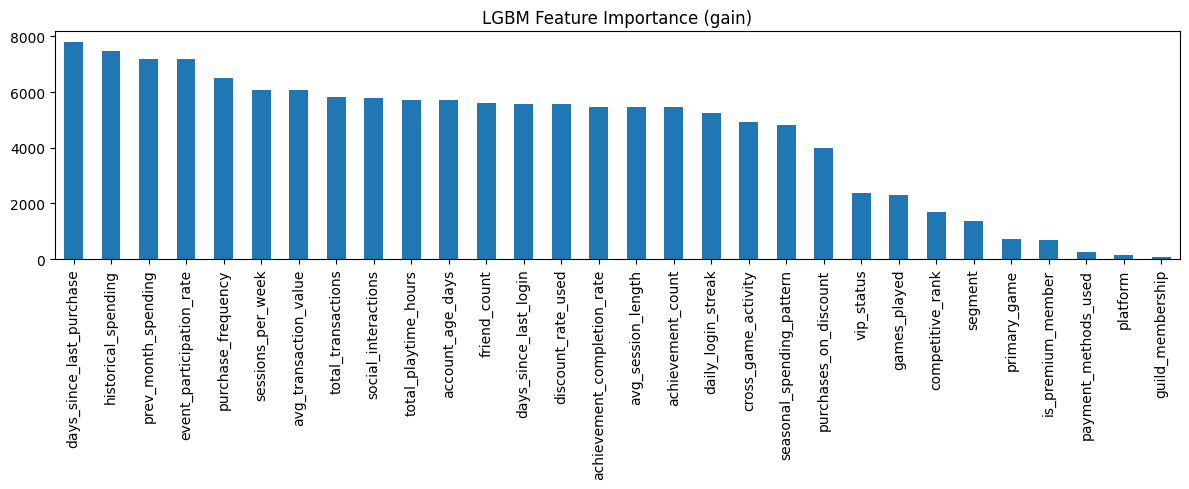

In [ ]:
# extract trained LGB model from pipeline
lgb_model = best_reg.named_steps["reg"]
# We need feature names after preprocessor: get numeric + categorical positions
feature_names = num_features + cat_features

# LightGBM feature importance
imp = pd.Series(lgb_model.feature_importances_, index=feature_names)
imp.sort_values(ascending=False).head(30).plot(kind="bar", figsize=(12,5))
plt.title("LGBM Feature Importance (gain)")
plt.tight_layout()
plt.show()

12.2 CatBoost feature importance (classifier)

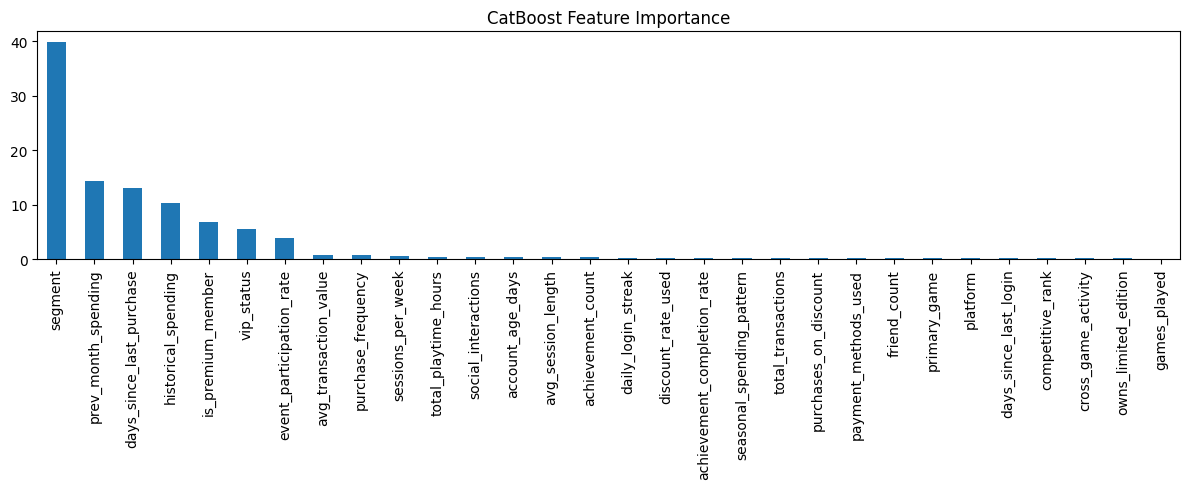

In [ ]:
cat_model = best_clf.named_steps["clf"]
# If CatBoost inside pipeline, feature names are the same:
cat_imp = pd.Series(cat_model.get_feature_importance(), index=feature_names)
cat_imp.sort_values(ascending=False).head(30).plot(kind="bar", figsize=(12,5))
plt.title("CatBoost Feature Importance")
plt.tight_layout()
plt.show()


12.3 SHAP (explain regressor predictions)

/tmp/ipython-input-805748086.py:8: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_trans, feature_names=feature_names)


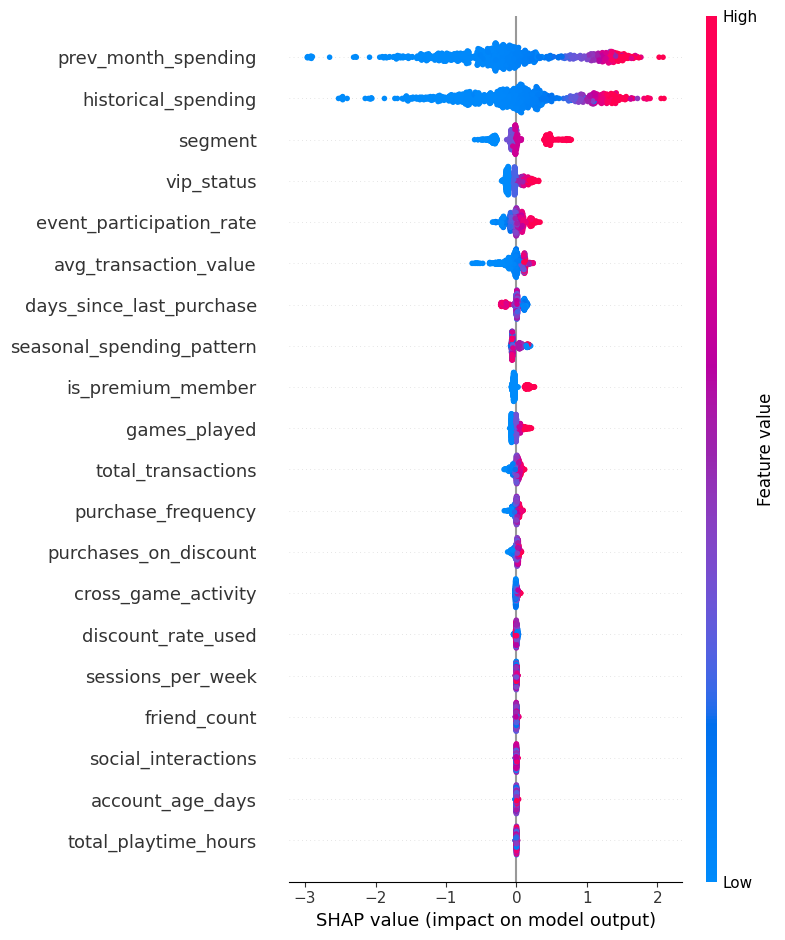

In [ ]:
# get preprocessed array for a sample (e.g., positive validation rows)
sample_X = X_train_reg_full.sample(n=1000, random_state=RANDOM_STATE)
X_trans = best_reg.named_steps["preproc"].transform(sample_X)

explainer = shap.TreeExplainer(best_reg.named_steps["reg"])
shap_values = explainer.shap_values(X_trans)  # this returns SHAP values for log prediction
# summary plot (numeric vector required)
shap.summary_plot(shap_values, X_trans, feature_names=feature_names)


13. Production inference function & model saving

In [ ]:
MODEL_DIR = Path("models")
MODEL_DIR.mkdir(exist_ok=True)

joblib.dump(best_clf, MODEL_DIR / "catboost_classifier_pipeline.joblib")
joblib.dump(best_reg, MODEL_DIR / "lgbm_regressor_pipeline.joblib")
# save feature lists
joblib.dump({"num_features": num_features, "cat_features": cat_features, "all_features": all_features}, MODEL_DIR / "feature_lists.joblib")


['models/feature_lists.joblib']

In [ ]:
def load_models(model_dir="models"):
    clf = joblib.load(Path(model_dir) / "catboost_classifier_pipeline.joblib")
    reg = joblib.load(Path(model_dir) / "lgbm_regressor_pipeline.joblib")
    features = joblib.load(Path(model_dir) / "feature_lists.joblib")
    return clf, reg, features

def predict_player_spend(df_players: pd.DataFrame, clf, reg, features):
    """
    df_players: DataFrame with the EXACT columns in features['all_features'].
    returns: array-like predicted THB spend for next 30 days.
    """
    # ensure columns order
    X_in = df_players[features["all_features"]].copy()
    p = clf.predict_proba(X_in)[:,1]
    pred_log = reg.predict(X_in)
    pred_spend = np.expm1(pred_log)
    final = p * pred_spend
    return final

# usage
clf_loaded, reg_loaded, feat = load_models("models")
sample = X.sample(3)
print(predict_player_spend(sample, clf_loaded, reg_loaded, feat))


[2.56499056e+00 2.68635111e+02 8.95800413e+04]


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [ ]:
import pandas as pd
import numpy as np
import joblib
from pathlib import Path

# -----------------------------
# Load models & feature metadata
# -----------------------------
def load_models(model_dir="models"):
    clf = joblib.load(Path(model_dir) / "catboost_classifier_pipeline.joblib")
    reg = joblib.load(Path(model_dir) / "lgbm_regressor_pipeline.joblib")
    features = joblib.load(Path(model_dir) / "feature_lists.joblib")
    return clf, reg, features


# -----------------------------
# Prediction function
# -----------------------------
def predict_player_spend(df_players: pd.DataFrame, clf, reg, features):
    X_in = df_players[features["all_features"]].copy()

    # Stage 1: Probability of spending
    p = clf.predict_proba(X_in)[:, 1]

    # Stage 2: Expected spend among spenders (log scale)
    pred_log = reg.predict(X_in)
    pred_spend = np.expm1(pred_log)

    # Final expected value
    final = p * pred_spend

    return p, pred_spend, final


# -----------------------------
# Main execution
# -----------------------------
if __name__ == "__main__":
    # 1. Load test data
    test_df = pd.read_csv("task3/test.csv")

    # 2. Load trained models
    clf_loaded, reg_loaded, feat = load_models("models")

    # 3. Predict
    p_spend, spend_est, final_expected = predict_player_spend(
        test_df, clf_loaded, reg_loaded, feat
    )

    # 4. Append predictions to DataFrame
    test_df["prob_spend"] = p_spend
    test_df["predicted_spend_if_spend"] = spend_est
    test_df["expected_spend_final"] = final_expected

    # 5. Export results
    output_path = "predictions.csv"
    test_df.to_csv(output_path, index=False)

    print(f"✓ Prediction file saved as: {output_path}")


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


✓ Prediction file saved as: predictions.csv
